# Camera robot kalibratie

> Uit vorige opdracht hebben we de intrinsieke camera matrix gehaald, deze zet coördinaten in camera frame om naar pixelcoördinaten. Het definiëren van objecten in het cameraframe is echter niet erg handig. Meestal kan je een een camera niet echt zien waar het frame zit en kan je moeilijk exacte afstanden meten vanaf de camera. Als we objecten willen definiëren in een custom assenstelsel om daarna de punten in dit assenstelsel te projecteren in camera frame en vervolgens in pixel coördinaten, dan kunnen we dit doen met de extrinsieke camera matrix. Dit is de matrix die metrische coördinaten (U, V, W) in een custom frame omzet in metrische coördinaten (X, Y, Z) in het camera frame. We kunnen dit schrijven in matrix notatie: 

$$\begin{bmatrix} X \\ Y \\ Z \end{bmatrix} = \begin{bmatrix} r_{11} & r_{12} & r_{13} & t_{x} \\ r_{21} & r_{22} & r_{23} & t_{y} \\ r_{31} & r_{32} & r_{33} & t_{z}\\ 0 & 0 & 0 & 1 \end{bmatrix}*\begin{bmatrix} U\\ V \\ W \end{bmatrix}$$ 

> Of ook als:

$$\begin{bmatrix} X \\ Y \\ Z \end{bmatrix} = {}^{w}T_{c} *\begin{bmatrix} U\\ V \\ W \end{bmatrix}$$ 

> Met T zijnde een transformatiematrix die punten omzet van één assenstelsel naar het andere. ${}^{w}T_{c}$ is de rigide transformatie van het {w} frame naar het {c} frame (let op de positie van de indices).



> De extrinsieke camera kalibratie berekent de parameters van deze transformatie op een gelijkaardige manier als bij de intrinsieke kalibratie. We gaan ook een set van wereldcoördinaten definiëren op een dambordpatroon. Deze matchen we dan terug met de corresponderende pixelcoördinaten uit het corner detection algoritme. 









# 1. Import libraries

Deze bibliotheken zijn nodig voor het volbrengen van dit script. In de CameraCalibration bibliotheek vind je de code achter de commando's die je hier zal gebruiken. 

In [2]:
import sys
sys.path.append('/content/drive/My Drive/object_pose_estimation_online')
from Classes.CameraCalibration import *
from google.colab.patches import cv2_imshow

# 2. Importeer alle beelden voor camera kalibratie

> Alle afbeeldingen bevinden zich onder de map /content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images. Als je dit uitprint kan je zien dat dit een array is met alle 10 de padnamen naar elke afbeelding. 

In [3]:
# Get all image's path names
robot_camera_calibration_images_file = '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/CRC_image_original_*.jpg'
images_path_names = get_image_path_names(robot_camera_calibration_images_file)
print(images_path_names)

['/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/CRC_image_original_1.jpg', '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/CRC_image_original_10.jpg', '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/CRC_image_original_2.jpg', '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/CRC_image_original_3.jpg', '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/CRC_image_original_4.jpg', '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/CRC_image_original_5.jpg', '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/CRC_image_original_6.jpg', '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/CRC_image_original_7.jpg', '/content/drive/My Drive/object_pose_estimatio



> We kunnen terug kijken hoe een dergelijke afbeelding eruit ziet. Merk op dat het dambordpatroon deze keer wordt vastgehouden door de robot.



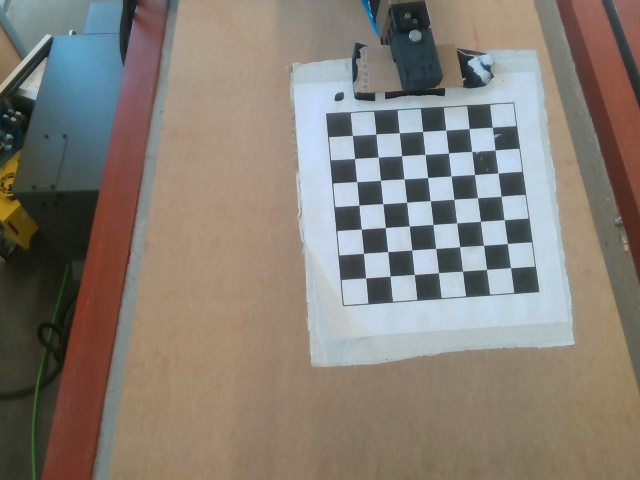

In [4]:
# Preview image
image_path = images_path_names[0]
image = read_image(image_path)
cv2_imshow(image)

# 3. Laden van de baselink-target transformatie matrices opgeslagen voor de 10 posities uit de 10 afbeeldingen

> Voor elke afbeelding van het dambordpatroon zullen we de transformatie matrix ${}^{C}T_{T}$ berekenen van camera frame naar target frame door middel van extrinsieke kalibratie. Om de gewenste baselink-camera transformatie ${}^{B}T_{C}$ te bekomen, hebben we nog de transformatiematrix nodig van baselink naar het target ${}^{B}T_{T}$, dit komt uit onze voorwaartse kinematica van de robot en hebben we reeds opgeslagen in /content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/baselink_target_transformations.npy. Je kan deze array printen en zien dat deze inderdaad 10 keer een 4x4 transformatiematrix bevat.



In [ ]:
# Baselink-target trasnformations filename
baselink_target_transformations_file = '/content/drive/My Drive/object_pose_estimation_online/data/camera_robot_calibration_images/baselink_target_transformations.npy'

In [ ]:
# Get all corresponding transformation matrices (numpy data)
baselink_target_transformations = get_numpy_data(baselink_target_transformations_file)
print(np.shape(baselink_target_transformations))

(10, 4, 4)


In [ ]:
# Get corresponding Baselink - Target transform for the 0th image
bt_transform = baselink_target_transformations[0]

# 4. Laden van de berekende intrinsieke camera matrix

> In vorige opgave heb je de intrinsieke matrix opgelsagen, deze werd automatisch opgeslagen onder /content/drive/My Drive/object_pose_estimation_online/data/matrix_files/intrinsic_camera_properties.npz. Deze kunnen we nu laden. De functie "load_intrinsic_camera_matrix" geeft je niet enkel de intrinsieke matrix, maar ook de distrotiecoëfficiënten nodig voor de kalibratie.





In [5]:
# Intrinsic camera matrix filename
intrinsic_camera_matrix_file = '/content/drive/My Drive/object_pose_estimation_online/data/matrix_files/intrinsic_camera_properties.npz'

In [6]:
# Load intrinsic camera matrix and distortion coefficients
mtx, dist = load_intrinsic_camera_matrix(intrinsic_camera_matrix_file)

# 5. Camera-robot kalibratie

> In dit deel zal je zelf de camera-robot calibratie uitvoeren, met andere woorden zal je de baselink-camera transformatiematrix ${}^{B}T_{C}$ bekomen. Je definieert terug de wereldcoordinaten van het dambordpatroon. Je leest vervolgens een beeld uit, zet het om naar grayscale, detecteert de hoekpunten in pixels, en voert vervolgens de extrinsieke calibratie uit. 


In [ ]:
# Prepare object points in 3D space in meters
objp = get_object_points()

In [ ]:
# Read image
image = read_image(image_path)

In [ ]:
# Turn image to grayscale
gray = image_to_grayscale(image)

In [ ]:
# Find the corners in the chessbord calibration tool
corners = find_corners(gray)

In [ ]:
# Get extrinsic camera calibration matrix (camera-target transform)
ct_transform = extrinsic_calibration(image, objp, corners, mtx, dist)
print(ct_transform)



> Nu dat je de transformatiematrix van het cameraframe naar het targetframe ${}^{C}T_{T}$ hebt, kan de deze gebruiken samen met de ${}^{B}T_{T}$ matrix om de totale ${}^{B}T_{C}$ matrix te bekomen. Let op dat je ${}^{C}T_{T}$ eerst nog moet inverteren! De baselink-camera matrix bereken je namelijk als volgt:

$${}^{B}T_{C} = {}^{B}T_{T} * {}^{T}T_{C} $$



In [ ]:
# Invert the transform
tc_transform = invert_transform(ct_transform)

In [ ]:
# Compute Baselink - Camera transform using "multiply_transform" function
bc_transform = multiply_transforms(bt_transform, tc_transform)

In [ ]:
# Save the mean baselink - camera transformation matrix
baselink_camera_transformation_file = '/content/drive/My Drive/object_pose_estimation_online/data/matrix_files/mean_baselink_camera_transformation'
save_to_numpy(baselink_camera_transformation_file, bc_transform)

In [ ]:
print("\nMean camera-robot transformation\n")
print(bc_transform)


Mean camera-robot transformation

[[ 0.99386435  0.08581828 -0.06977735 -0.02585932]
 [ 0.10647747 -0.9130998   0.39358774 -1.06063782]
 [-0.02993666 -0.39860253 -0.91663505  0.75004694]
 [ 0.          0.          0.          1.        ]]


# 6. Test camera-target calibration

> In wat volgt kunnen we de kalibratie testen. De extrinsieke matrix geeft ons namelijk weer welke camera coördinaten overeenkomen met objecten gepositioneerd op een bepaalde locatie in het target frame {T}. Samen met de reeds berekende intrinsieke matrix die camera coördinaten omzet in pixel coördinaten kunnen we dus coördinaten van een object die we virtueel plaatsen in het target frame projecteren in pixel frame (dit is de basis van Augmented Reality). Hierbij laden we eerst terug onze berekende intrinsieke camera matrix.



In [ ]:
# Load intrinsic camera matrix and distortion coefficients
intrinsic_camera_matrix_file = "/content/drive/My Drive/object_pose_estimation_online/data/matrix_files/intrinsic_camera_properties.npz"
mtx, dist = load_intrinsic_camera_matrix(intrinsic_camera_matrix_file)

> We definiëren twee zaken:


*   De coordinaten van het target assenstelsel. We definiëren de oorsprong op (X, Y, Z) = (0, 0, 0) in het target frame, de x-as op (X, Y, Z) = (0.6, 0, 0) , de y-as op (X, Y, Z) = (0, 0.6, 0), en de z-as op (X, Y, Z) = (0, 0, 0.6). 
*   De coördinaten van een virtuele kubus van 0.04x0.04x0.4 meter in het target frame. 

> Voor deze beide zaken maken we gebruik van de intrinsieke en extrinsieke matrix om te kijken met welke pixels deze overeenkomen. Als we deze pixels berekenen en projecteren op het beeld, dan krijgen we het effect alsof deze zaken zich werkelijk in de ruimte (gedefiniëerd in target frame) bevinden.

In [7]:
# Define axis and box coordinates in camera coordinate system
axis = np.float32([[0.06, 0, 0], [0, 0.06, 0], [0, 0, 0.06], [0, 0, 0]])
box = np.float32([[0.08, 0.06, 0], [0.12, 0.06, 0], [0.12, 0.10, 0], [0.08, 0.10, 0], [0.08, 0.06, -0.04],
                          [0.12, 0.06, -0.04], [0.12, 0.10, -0.04], [0.08, 0.10, -0.04]]).reshape(-1, 3)

In [ ]:
# Retrieve rotation matrix and translation vector from ct_transform
ct_rot = ct_transform[:3, :3]
ct_trans = ct_transform[0:3, 3]

In [ ]:
# Project 3D axis points to pixel coordinates
imgpts_axis, _ = cv2.projectPoints(axis, ct_rot, ct_trans, mtx, dist)

# Draw axis on image
image = draw_axis(image, imgpts_axis)

# Project 3D box points to pixel coordinates
imgpts_box, _ = cv2.projectPoints(box, ct_rot, ct_trans, mtx, dist)

# Draw box on image
image = draw_box1(image, imgpts_box)

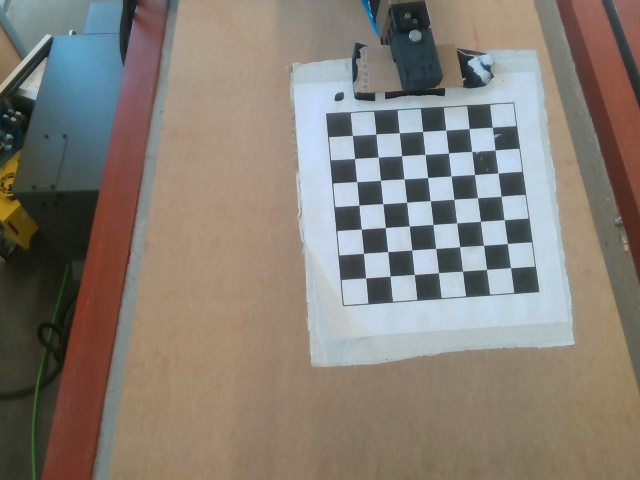

In [8]:
# Show result
cv2_imshow(image)

# 7. Test robot-camera calibration

> We kunnen ook de robot-camera kalibratie testen. De berekende ${}^{B}T_{C}$ kan namelijk punten omzetten gedefiniëerd in robot frame, in camera frame. Samen met de intrinsieke matrix kunnen we dus punten omzetten van robot frame in pixel frame en dus virtueel geplaatste objecten in robot frame visulaiseren in de afbeelding. We definiëren hier tevens een kubus maar nu in coördinaten gedefiniëerd ten opzichte van het robot frame. Je brein zal hoogst waarschijnlijk even de tijd nodig hebben om te zien dat de kubus wel degenlijk correct geplaatst is voor de robot. 






In [ ]:
# Define axis and box coordinates in camera coordinate system
box = np.float32([[-0.1, -0.6, 0], [-0.1, -0.7, 0], [-0.2, -0.7, 0], 
                  [-0.2, -0.6, 0], [-0.1, -0.6, -0.1], [-0.1, -0.7, -0.1], [-0.2, -0.7, -0.1], 
                  [-0.2, -0.6, -0.1]]).reshape(-1, 3)

In [ ]:
# Retrieve rotation matrix and translation vector from bc_transform
cb_transform = invert_transform(bc_transform)
cb_rot = cb_transform[:3, :3]
cb_trans = cb_transform[0:3, 3]

In [ ]:
# Project 3D box points to pixel coordinates
imgpts_box, _ = cv2.projectPoints(box, cb_rot, cb_trans, mtx, dist)

# Draw box on image
image = draw_box1(image, imgpts_box)

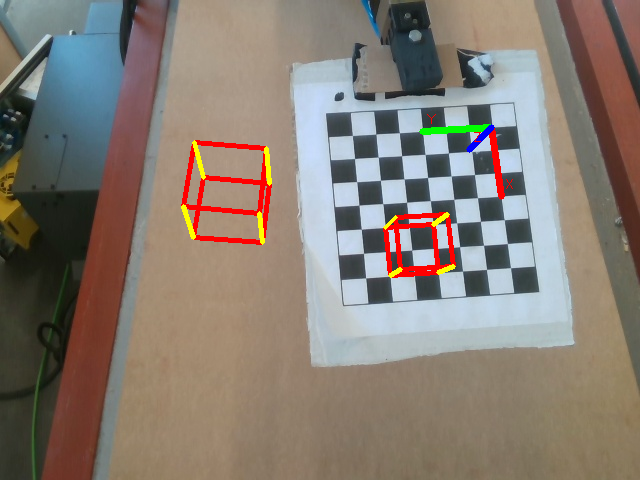

In [ ]:
# Show result
cv2_imshow(image)